## Car Rental Problem

### Exercise 4.7 (programming)

Write a program for policy iteration and re-solve Jack’s car
rental problem with the following changes. One of Jack’s employees at the first location
rides a bus home each night and lives near the second location. She is happy to shuttle
one car to the second location for free. Each additional car still costs 2, as do all cars
moved in the other direction. In addition, Jack has limited parking space at each location.
If more than 10 cars are kept overnight at a location (after any moving of cars), then an
additional cost of 4 must be incurred to use a second parking lot (independent of how
many cars are kept there). These sorts of nonlinearities and arbitrary dynamics often
occur in real problems and cannot easily be handled by optimization methods other than
dynamic programming. To check your program, first replicate the results given for the
original problem.

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from scipy.special import factorial

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline

### Solving original problem

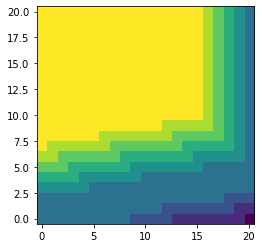

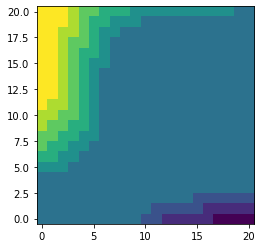

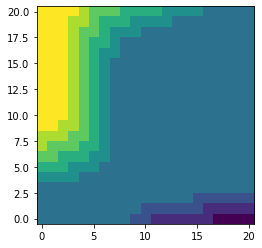

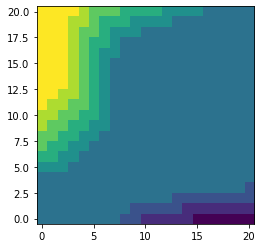

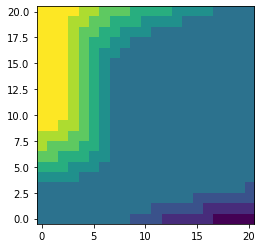

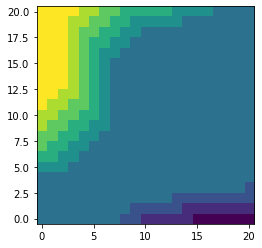

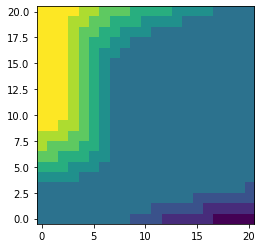

In [53]:
"""
Parameters:
n_cars:        Max #cars allowed at each lot
n_cars_mv:     Max #cars moved between lots each step
V:             Initial state-value function
PI:            Initial policy
theta:         Policy evaluation convergence constant
gamma:         Return discount parameter
lambda_req:    Parameters for car request poisson r.v.
lambda_ret:    Parameters for car return poisson r.v.
"""
n_cars1 = 20
n_cars2 = 20
n_cars_mv = 5
V = np.zeros((n_cars1+1, n_cars2+1))
PI = np.zeros((n_cars1+1, n_cars2+1), dtype=int)
theta = 0.00001
gamma = 0.9
lambda_req = [3,4]
lambda_ret = [3,2]

PICKLE_DIR = "RL_ex4_7_data/"

def evaluate_policy(pi, v):
    """
    Evaluate a policy by determining expected returns at each state.
    
    Intuitively, the value at each state is updated to reflect 
        the new policy's action at the current state.
    This implementation does not sum over environment probabilities, 
        but instead uses the mean of poisson random variables.
    
    Parameters
    ----------
        pi : ndarray(shape=(n_cars1+1,n_cars2+1), dtype=int)
            Policy to be evaluated 
        v : ndarray(shape=(n_cars1+1,n_cars2+1), dtype = float)
            Current state-value function
            
    Returns
    -------
    ndarray 
        State-value function after evaluating pi
    """
    while True:
        delta = 0
        for i in range(n_cars1+1):
            for j in range(n_cars2+1):
                v_old = v[i,j]
                a = pi[i,j]
                i_day = max(i-a, 0)
                j_day = max(j+a, 0)
                reward = 10 * (min(i_day, lambda_req[0]) + min(j_day, lambda_req[1])) - 2 * abs(a)
                i_p = min(max(i_day-lambda_req[0], 0) + lambda_ret[0], n_cars1)
                j_p = min(max(j_day-lambda_req[1], 0) + lambda_ret[1], n_cars2)
                s_p = [i_p, j_p]
                v[i,j] = reward + gamma * v[s_p[0],s_p[1]]
                delta = max(delta, np.abs(v[i,j]-v_old))
        if (delta < theta):
            return v

def improve_policy(pi, v, dynamics):
    """
    Updates policy greedily w.r.t. to previously calculated state-values.
    
    For each state, the new policy chooses the action 
        that gives the highest expected returns.
    Uses a dictionary to lookup environment dynamics for state-action
    Checks policy stability via lookback. If a state-value function has been seen before,
        then the policy is stable
    Multiple optimal policies are possible, hence the lookback to prevent infinite loops
        
    Parameters
    ----------
        pi : ndarray(shape=(n_cars1+1,n_cars2+1), dtype=int)
            Policy to be improved
        v : ndarray(shape=(n_cars1+1,n_cars2+1), dtype = float)
            Current state-value function
        dynamics : dict
            Environment dynamics
            f(s'r|s,a) = p(s',r|s,a) = { (s,a): { (s',r): y } }
    Returns
    -------
        (ndarray, ndarray)
        Optimal policies and state-value functions
    """
    lookback = 100
    policies = []
    reward_rec = []
    
    while True:
        policy_stable = True
        for i in range(n_cars1+1):
            for j in range(n_cars2+1):
                if (i != 0 or j != 0):
                    
                    actions = np.arange(-min(n_cars_mv,j), 
                                        min(n_cars_mv,i) + 1, 1, 
                                        dtype=float)
                    actions = actions[np.where(
                                    (actions <= i) & 
                                    (-actions <= j) & 
                                    (-actions + i <= n_cars1) & 
                                    (actions + j <= n_cars2))]
                    action_returns = np.zeros(actions.size)
                    for n, a in enumerate(actions):
                        cond_dynamics = dynamics[(i, j, a)]
                        action_return = 0
                        for k in cond_dynamics.keys():
                            action_return += cond_dynamics[k] * (k[2] + 
                                                                 gamma * 
                                                                 v[k[0], k[1]])
                        action_returns[n] = action_return

                    pi[i,j] = actions[np.argmax(action_returns)]
        
        v = evaluate_policy(pi, v)
        if (np.sum(v) not in reward_rec):
            plt.figure()
            plt.imshow(pi, origin='lower')
            plt.show()
            policy_stable = False
            policies.append(pi)
            reward_rec.append(np.sum(v))
            if (len(policies) > lookback):
                policies.pop(0)
                reward_rec.pop(0)

        if policy_stable:
            return (policies, v)

def eval_poisson(l, n):
    """
    Evaluates probability P(n) according to poisson(l) distribution
    
    Parameters
    ----------
        l : list
            Poisson parameters
        n : list
    
    Returns
    -------
        ndarray
            Probabilities
    """
    return np.maximum(np.repeat(np.finfo(float).eps,len(l)), 
                      np.abs(np.divide(np.multiply(np.power(l, n), 
                                                   np.exp(np.multiply(l, -1))), 
                                       factorial(n))))
        
def train():
    """
    Calculate environment dynamics
    
    For each (s',r,s,a), calculate its probability
    s' and r are indirectly determined from (reqx,reqy,retx,retx),
        the number of requests/returns on each site
    (reqx,reqy,retx,rety) makes up a joint distribution of poisson r.v.s
    
    Returns
    -------
        dict
            f(s'r|s,a) = p(s',r|s,a) = { (s,a): { (s',r): y } }
    """
    all_possibilities = {}
    for reqx in range(n_cars1+1):
        for reqy in range(n_cars2+1):
            for retx in range(n_cars1+1):
                for rety in range(n_cars2+1):
                    all_possibilities[(reqx, reqy, retx, rety)] = np.prod(eval_poisson([lambda_ret[0], lambda_ret[1], lambda_req[0], lambda_req[1]], 
                                                                             [retx, rety, reqx, reqy]))

    P = {}
    for sx in range(n_cars1+1):
        print("State: {}".format(sx))
        for sy in range(n_cars2+1):
            for a in np.arange(-n_cars_mv, n_cars_mv +1, 1, dtype=int):
                if a <= sx and -a <= sy and -a + sx <= n_cars1 and a + sy <= n_cars2:
                    P[(sx,sy,a)] = {}
                    for reqx in range(n_cars1+1):
                        for reqy in range(n_cars2+1):
                            r = int(10 * min(sx - a, reqx) + 10 * min(sy + a, reqy) - 2 * abs(a))
                            for retx in range(n_cars1+1):
                                for rety in range(n_cars2+1):
                                    sx_p = min(max(sx - a - reqx, 0) + retx, n_cars1)
                                    sy_p = min(max(sy + a - reqy, 0) + rety, n_cars2)
                                    if (sx_p,sy_p,r) in P[(sx,sy,a)]:
                                        P[(sx,sy,a)][(sx_p,sy_p,r)] += all_possibilities[(reqx, reqy, retx, rety)]
                                    else:
                                        P[(sx,sy,a)][(sx_p,sy_p,r)] = all_possibilities[(reqx, reqy, retx, rety)]

    return P


if __name__ == "__main__":
    #dynamics = train()
    #with open(PICKLE_DIR + 'dynamics.pickle', 'wb') as handle:
        #pickle.dump(dynamics, handle, protocol=pickle.HIGHEST_PROTOCOL)
    #with open(PICKLE_DIR + 'dynamics.pickle', 'rb') as handle:
        #dynamics = pickle.load(handle)
    v = evaluate_policy(PI,V)
    (policies, v) = improve_policy(PI, v, dynamics)


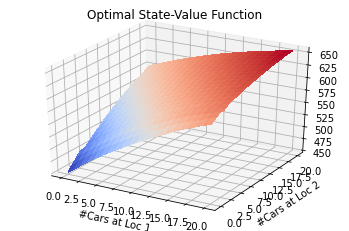

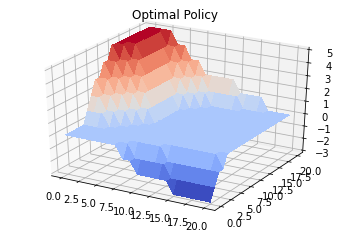

In [54]:
fig = plt.figure()
ax = fig.gca(projection='3d')

# Plot the surface.
X = np.arange(0,n_cars1+1,1)
Y = np.arange(0,n_cars2+1,1)
X, Y = np.meshgrid(X, Y) 
surf = ax.plot_surface(X, Y, v, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

plt.title('Optimal State-Value Function')
plt.xlabel('#Cars at Loc 1')
plt.ylabel('#Cars at Loc 2')
plt.show()

fig = plt.figure()
ax = fig.gca(projection='3d')

# Plot the surface.
X = np.arange(0,n_cars1+1,1)
Y = np.arange(0,n_cars2+1,1)
X, Y = np.meshgrid(X, Y) 
surf = ax.plot_surface(X, Y, policies[-1], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
plt.title('Optimal Policy')
plt.show()

### Solving problem as presented in ex4.7